# Loading the data / Data Understanding
As the first step, we load the Bondora loan dataset and perform an initial data quality check following CRISP-ML best practices.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load the dataset
df = pd.read_csv('data/LoanData.csv')

# Display the first few rows of the dataset
df.head()

/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_36565/2970069874.py:8: DtypeWarning: Columns (10,56,73,74,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/LoanData.csv')


,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,...,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory,LoanCancelled,PreviousEarlyRepaymentsBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,3015853,2022-09-09 12:27:01,2022-09-09 15:27:01,11.0,0.0,88.0,False,2022-09-09 15:15:03,2022-09-09,...,NaN,2024-05-27,6.0,23.0,2023-11-30,NaN,NaN,NaN,NaN,NaN
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,3743447,2023-05-19 11:04:33,2023-05-19 14:04:33,0.0,0.0,0.0,False,2023-05-19 14:03:54,2023-05-19,...,NaN,2024-05-27,11.0,120.0,2023-07-20,NaN,NaN,91-120,NaN,NaN
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,4335414,2024-02-03 14:43:32,2024-02-03 16:43:32,0.0,0.0,0.0,False,2024-02-03 16:41:51,2024-02-03,...,NaN,2024-07-08,2.0,12.0,2024-05-12,NaN,NaN,NaN,NaN,NaN
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970.0,1150.0,5.0,False,2016-03-17 12:39:22,2016-03-23,...,2020-01-27,NaN,NaN,NaN,NaN,0.0,82.76,180+,NaN,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,4043783,2023-09-26 12:14:12,2023-09-26 15:14:12,0.0,0.0,0.0,False,2023-09-26 15:13:07,2023-09-26,...,NaN,2024-06-04,9.0,108.0,NaN,NaN,NaN,16-30,NaN,NaN


## Identifying the DtypeWarning
When loading the dataset, we encounter a warning:

`DtypeWarning: Columns (10,56,73,74,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/LoanData.csv')`

Let's investigate which columns are causing this warning and why.


In [2]:
# What columns are causing the warning?
flagged_indices = [10, 56, 73, 74, 94, 95]
flagged_columns = df.columns[flagged_indices]

# Display the columns causing the warning, their types, and an example value with index
for col in flagged_columns:
    print(f"\nColumn: {col}")
    col_types = df[col].map(type)
    for t in col_types.unique():
        example_series = df[col][col_types == t]
        example_index = example_series.index[0]
        example_value = example_series.iloc[0]
        print(f"Type: {t.__name__}, Example: {example_value}, Index: {example_index}")



Column: ContractEndDate
Type: str, Example: 2025-10-27, Index: 0
Type: float, Example: nan, Index: 4

Column: DefaultDate
Type: float, Example: nan, Index: 0
Type: str, Example: 2020-01-14, Index: 3

Column: CreditScoreEsEquifaxRisk
Type: float, Example: nan, Index: 0
Type: str, Example: B, Index: 14

Column: CreditScoreFiAsiakasTietoRiskGrade
Type: float, Example: nan, Index: 0
Type: str, Example: 3, Index: 1

Column: ActiveLateLastPaymentCategory
Type: float, Example: nan, Index: 0
Type: str, Example: 91-120, Index: 1

Column: LoanCancelled
Type: float, Example: nan, Index: 0
Type: bool, Example: False, Index: 389970


These attributes are specified as follows as per the API documentation (https://api.bondora.com/doc/ResourceModel?modelName=PublicDatasetItem&v=1):

- ContractEndDate = Date
- DefaultDate = Date
- CreditScoreEsEquifaxRisk = string
- CreditScoreFiAsiakasTietoRiskGrade = string
- ActiveLateLastPaymentCategory = string
- LoanCancelled = boolean

The warning is due to the fact that these columns are not being read in as the correct data types.

In [3]:
# Loading the CSV with specified dtypes to avoid the DtypeWarning
df = pd.read_csv(
    'data/LoanData.csv',
    dtype={

        'CreditScoreEsEquifaxRisk': 'category',
        'CreditScoreFiAsiakasTietoRiskGrade': 'category',
        'ActiveLateLastPaymentCategory': 'category',
        'LoanCancelled': 'boolean',
        'ContractEndDate': 'string', # Will be converted to datetime later
        'DefaultDate': 'string',
    },
)

# Convert date columns to datetime format
df['ContractEndDate'] = pd.to_datetime(df['ContractEndDate'], errors='coerce')
df['DefaultDate'] = pd.to_datetime(df['DefaultDate'],     errors='coerce')

In [4]:
# Note that we used boolean for LoanCancelled, and not bool, as the latter does not support NaN values.
df['LoanCancelled'].value_counts(dropna=False)

LoanCancelled
<NA>     389970
False     10099
True        101
Name: count, dtype: Int64

# Continuing with Data Understanding: Dataset Characteristics
We have successfully loaded the dataset without warnings, keeping data preprocessing to a minimum. Now, let's continue with our data understanding phase.

## Characteristic 1: Missing Values

To understand the dataset better, we will analyze whether there are missing values in the dataset, and what implications this has.

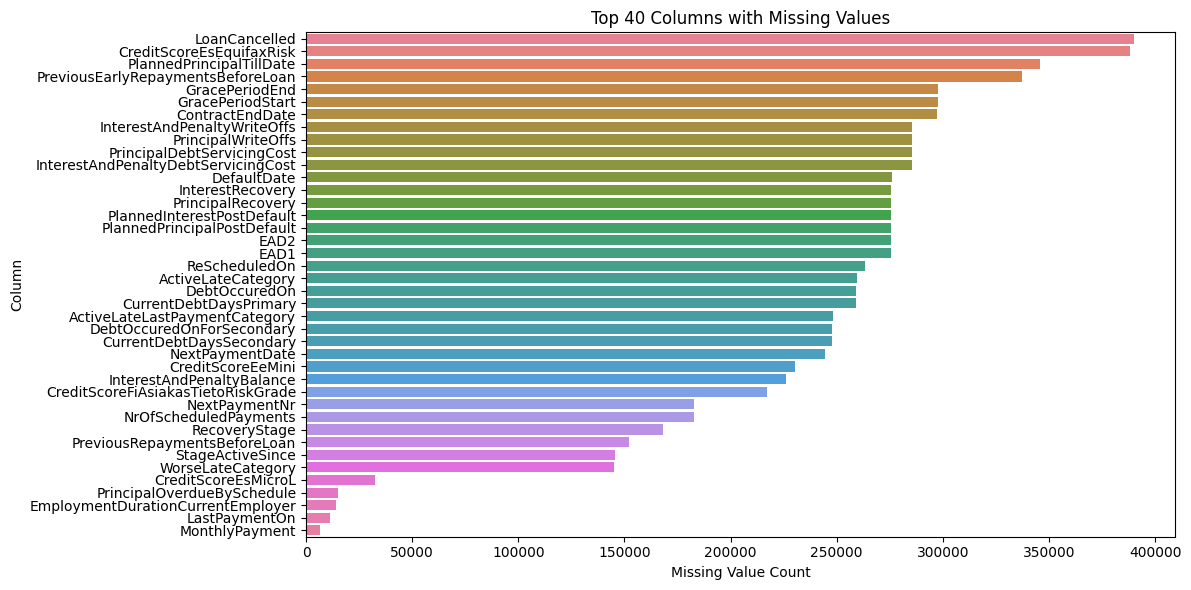

,Column,MissingCount,MissingPercent
0,LoanCancelled,389970,97.45
1,CreditScoreEsEquifaxRisk,387951,96.95
2,PlannedPrincipalTillDate,345706,86.39
3,PreviousEarlyRepaymentsBeforeLoan,337407,84.32
4,GracePeriodEnd,297894,74.44
5,GracePeriodStart,297894,74.44
6,ContractEndDate,297159,74.26
7,InterestAndPenaltyWriteOffs,285617,71.37
8,PrincipalWriteOffs,285617,71.37
9,PrincipalDebtServicingCost,285617,71.37


In [5]:
# Total number of rows
total_rows = len(df)

# Compute missing counts
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

# Build DataFrame
missing_df = missing_values.reset_index()
missing_df.columns = ['Column', 'MissingCount']

# Add percentage column
missing_df['MissingPercent'] = (missing_df['MissingCount'] / total_rows * 100).round(2)

# Plot the top 40 columns by missing count
plt.figure(figsize=(12, 6))
sns.barplot(
    data=missing_df.head(40),
    x='MissingCount',
    y='Column',
    hue='Column',
    legend=False,
)
plt.title("Top 40 Columns with Missing Values")
plt.xlabel("Missing Value Count")
plt.ylabel("Column")
plt.tight_layout()
plt.show()

# Display the DataFrame
missing_df.head(40)

### Insights from the Missing Values Analysis

  Missingness here seems structural, driven by loan lifecycle stage (active vs. defaulted vs. cancelled) and regional score availability. Many nulls are informative rather than random, and thus means that this pattern holds semantic information, e.g. `has_defaulted` , `has_grace_period` could be extracted from this missingness, rather than assuming it is an error, and dropping or applying imputation.

- **Loan Status Flags**
  - `LoanCancelled` (97% missing): cancellations are rare, only ~2.5% of loans get cancelled, so most rows have no value.
  - `DefaultDate` (68.9% missing): only ~31% of loans have defaulted; the rest never hit default, hence no date. We can derive a binary `has_defaulted` flag from this.
- **Credit Bureau Scores**
  - `CreditScoreEsEquifaxRisk` (96.9%), `CreditScoreEsMicroL` (8.1%), `CreditScoreEeMini` (57.6%), `CreditScoreFiAsiakasTietoRiskGrade` (54.3%): scores come from different bureaus/markets. Assuming only loans in those regions have these scores, missingness reflects geographic coverage.
- **Payment Schedule & Balances**
  - `PlannedPrincipalTillDate` (86.4%), `NextPaymentDate` (61.1%), `NrOfScheduledPayments` (45.7%): schedule data applies only to active or unpaid loans. Completed or cancelled loans lack these fields.
  - `InterestAndPenaltyBalance` (56.5%): shows outstanding interest/penalty only for delinquent accounts.
- **Delinquency & Late‐Payment Metrics**
  - `ActiveLateCategory`, `ActiveLateLastPaymentCategory`, `WorseLateCategory` (36-65% missing): defined only for borrowers who’ve been late. Missing = on‐time or no late payments.
- **Default & Recovery Figures**
  - `PrincipalWriteOffs`, `InterestAndPenaltyWriteOffs` (71%), `PrincipalRecovery`, `InterestRecovery` (69%): amounts written off or recovered post‐default. Non‐defaulted loans assumingly should not have these.
- **Exposure at Default (EAD)**
  - `EAD1`, `EAD2` (~68.8% missing): credit‐risk exposures estimated for loans that defaulted; should be absent for performing loans.
- **Rescheduling & Grace Period**
  - `ReScheduledOn` (65.8%), `GracePeriodStart`/`GracePeriodEnd` (74.4%): only relevant when a borrower enters a grace period or reschedules, most never do.
- **Lifecycle Timestamps**
  - `ContractEndDate` (74.3%), `StageActiveSince` (36.4%), `DebtOccuredOn`, `DebtOccuredOnForSecondary` (64-62%): various event dates in the loan lifecycle; missing when the event hasn’t happened.
- **Low‐Missing Core Features**
  - `PrincipalOverdueBySchedule` (3.7%), `EmploymentDurationCurrentEmployer` (3.5%), `LastPaymentOn` (2.9%), `MonthlyPayment` (1.7%): essential borrower/loan characteristics available for nearly all records.



## Characteristic 2: Data Uniqueness

Next, we will check the uniqueness of the data as a sanity check. We will do so by checking for duplicates, and by checking the number of unique values in each column.

In [6]:
# Check the number of unique values in each column
unique_counts = df.nunique().sort_values(ascending=False)
unique_counts

LoanId                               400170
LoanNumber                           400166
BiddingStartedOn                     398634
ListedOnUTC                          398622
LoanApplicationStartedDate           398565
                                      ...  
RecoveryStage                             3
Restructured                              2
NewCreditCustomer                         2
LoanCancelled                             2
ActiveScheduleFirstPaymentReached         2
Length: 97, dtype: int64

In [7]:
# Lets ensure that LoanId is unique
if df['LoanId'].nunique() == len(df):
    print("LoanId is unique across all rows.")
else:
    print("LoanId is not unique across all rows.")

LoanId is unique across all rows.


In [8]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
if duplicate_rows > 0:
    print(f"Number of duplicate rows: {duplicate_rows}")
else:
    print("No duplicate rows found.")

No duplicate rows found.


## Characteristic 3: Target Variable Analysis

Moving on, let's inspect the behavior of our (potential) target variables, that could help with assessing credit risk. In this dataset, we could look at three outcomes for each loan:

1. Repaid: The borrower completed all scheduled payments.
2. Defaulted: The borrower missed sufficient payments and entered default.
3. Cancelled: The loan was cancelled before disbursement or early in its lifecycle.


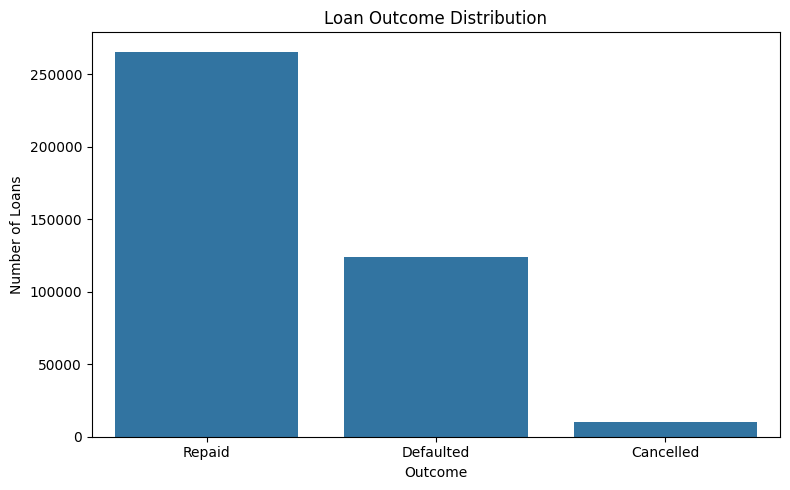

            count      %
Outcome                 
Repaid     265733  66.41
Defaulted  124237  31.05
Cancelled   10200   2.55


In [9]:
# Create a categorical “outcome” column (if defaultdate is not null, then defaulted, if loancancelled is not null, then cancelled, otherwise repaid)
df['Outcome'] = (
    np.where(df['DefaultDate'].notnull(), 'Defaulted',
    np.where(df['LoanCancelled'].notnull(), 'Cancelled', 'Repaid'))
)

# Count and plot
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Outcome', order=['Repaid','Defaulted','Cancelled'])
plt.title('Loan Outcome Distribution')
plt.ylabel('Number of Loans')
plt.xlabel('Outcome')
plt.tight_layout()
plt.show()

# Show raw counts & proportions
counts = df['Outcome'].value_counts()
props = df['Outcome'].value_counts(normalize=True).mul(100).round(2)
print(pd.concat([counts, props.rename('%')], axis=1))

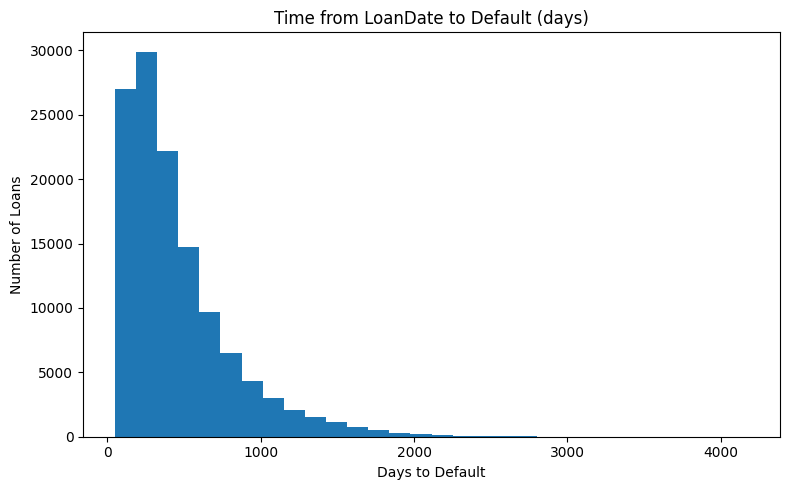

count    124237.0
mean        458.0
std         358.3
min          49.0
25%         204.0
50%         353.0
75%         592.0
max        4179.0
dtype: float64


In [10]:
df['LoanDate'] = pd.to_datetime(df['LoanDate'], errors='coerce')

# Compute days to default for only those that defaulted
mask = df['DefaultDate'].notna() & df['LoanDate'].notna()
t2d = (df.loc[mask, 'DefaultDate'] - df.loc[mask, 'LoanDate']).dt.days

plt.figure(figsize=(8,5))
plt.hist(t2d.dropna(), bins=30)
plt.title('Time from LoanDate to Default (days)')
plt.xlabel('Days to Default')
plt.ylabel('Number of Loans')
plt.tight_layout()
plt.show()

# Summary statistics
print(t2d.describe().round(1))

## Characteristic 4: Outliers & Extreme Values


In [11]:
# Identify numeric features (excluding obvious IDs)
numeric_cols = (
    df
    .select_dtypes(include=["number"])
    .columns
    .drop(['LoanId', 'LoanNumber'], errors='ignore')
)
numeric_cols

Index(['BidsPortfolioManager', 'BidsApi', 'BidsManual',
       'ApplicationSignedHour', 'ApplicationSignedWeekday', 'VerificationType',
       'LanguageCode', 'Age', 'Gender', 'AppliedAmount', 'Amount', 'Interest',
       'LoanDuration', 'MonthlyPayment', 'Education', 'OccupationArea',
       'HomeOwnershipType', 'IncomeFromPrincipalEmployer', 'IncomeFromPension',
       'IncomeFromFamilyAllowance', 'IncomeFromSocialWelfare',
       'IncomeFromLeavePay', 'IncomeFromChildSupport', 'IncomeOther',
       'IncomeTotal', 'ExistingLiabilities', 'LiabilitiesTotal',
       'RefinanceLiabilities', 'DebtToIncome', 'FreeCash', 'MonthlyPaymentDay',
       'PlannedPrincipalTillDate', 'PlannedInterestTillDate',
       'CurrentDebtDaysPrimary', 'CurrentDebtDaysSecondary', 'ExpectedLoss',
       'LossGivenDefault', 'ExpectedReturn', 'ProbabilityOfDefault',
       'PrincipalOverdueBySchedule', 'PlannedPrincipalPostDefault',
       'PlannedInterestPostDefault', 'EAD1', 'EAD2', 'PrincipalRecovery',
     

Top 10 features by IQR-based outlier percentage:


,feature,outliers_count,outliers_pct
52,InterestAndPenaltyWriteOffs,27560,24.058733
39,PrincipalOverdueBySchedule,82235,21.345879
51,PrincipalWriteOffs,23011,20.087645
54,InterestAndPenaltyBalance,30410,17.472794
5,VerificationType,67886,16.966410
63,PreviousEarlyRepaymentsBeforeLoan,10449,16.648344
16,HomeOwnershipType,65813,16.514643
36,LossGivenDefault,62062,15.611864
14,Education,60394,15.093972
1,BidsApi,56516,14.122998


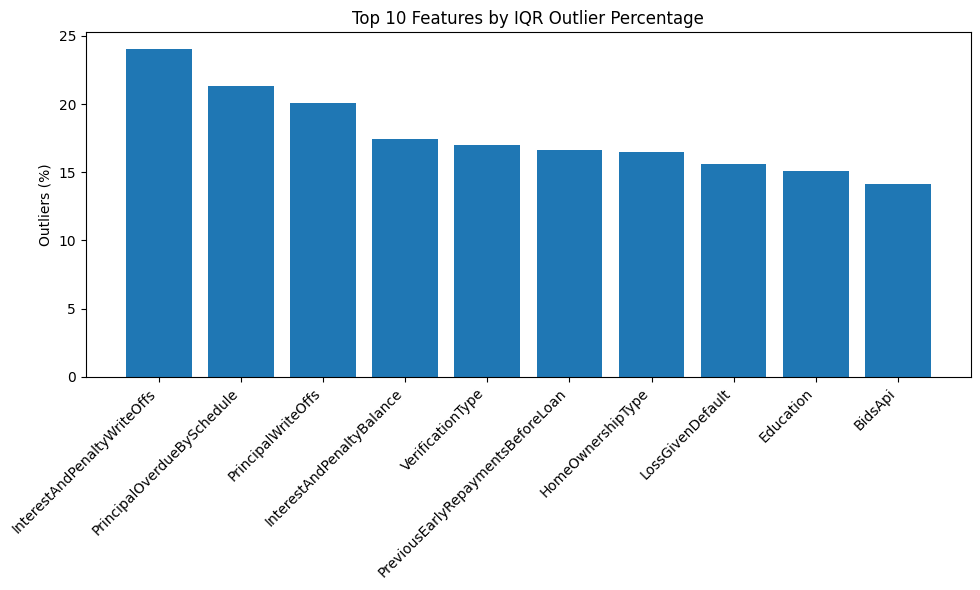

In [12]:
# Univariate outlier detection via IQR
iqr_summary = []
for col in numeric_cols:
    col_data = df[col].dropna()
    Q1, Q3 = col_data.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n_outliers = ((col_data < lower) | (col_data > upper)).sum()
    pct_outliers = n_outliers / len(col_data) * 100
    iqr_summary.append({
        'feature': col,
        'outliers_count': n_outliers,
        'outliers_pct': pct_outliers
    })

iqr_df = pd.DataFrame(iqr_summary).sort_values('outliers_pct', ascending=False)
print("Top 10 features by IQR-based outlier percentage:")
display(iqr_df.head(10))

# Bar chart of top-10 features
top10 = iqr_df.head(10).set_index('feature')
plt.figure(figsize=(10, 6))
plt.bar(top10.index, top10['outliers_pct'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Outliers (%)')
plt.title('Top 10 Features by IQR Outlier Percentage')
plt.tight_layout()
plt.show()


### Reviewing the results of the IQR analysis
Debt & write-off features show high outlier rates, likely because loans in default or with large write-offs are rare but extreme. This is expected in credit risk datasets, where most loans perform well, but a few default severely.

There are also some features with high outlier rates that are not directly related to default or write-off, and are not true numerical values (categories instead, but under the hood seen as numeric) such as `Education`, `HomeOwnershipType` this could just mean that some categories are less common.

In [13]:
# Z-score analysis: flag values with |z| > 3
zscore_summary = []
for col in numeric_cols:
    col_data = df[col].dropna()
    zs = np.abs(stats.zscore(col_data))
    n_z_outliers = (zs > 3).sum()
    pct_z = n_z_outliers / len(col_data) * 100
    zscore_summary.append({
        'feature': col,
        'z_outliers_count': n_z_outliers,
        'z_outliers_pct': pct_z
    })

zscore_df = pd.DataFrame(zscore_summary).sort_values('z_outliers_pct', ascending=False)
print("\nTop 10 features by Z-score (>3) outlier percentage:")
print(zscore_df.head(10))


Top 10 features by Z-score (>3) outlier percentage:
                       feature  z_outliers_count  z_outliers_pct
48           CreditScoreEeMini              7602        4.477216
15              OccupationArea             14384        3.595290
28                DebtToIncome             13801        3.449215
14                   Education             13714        3.427472
51          PrincipalWriteOffs              2995        2.614510
59               NextPaymentNr              5495        2.526390
39  PrincipalOverdueBySchedule              9712        2.520960
6                 LanguageCode              9938        2.483445
44           PrincipalRecovery              2967        2.379081
2                   BidsManual              9445        2.360247


### Reviewing the results of the Z-score analysis
“Numeric” categoricals (CreditScoreEeMini, OccupationArea, Education, LanguageCode) pop up as outliers simply because rare categories sit far from the mean.

Default‐related attributes (PrincipalWriteOffs, PrincipalOverdueBySchedule, PrincipalRecovery) are likely genuine extremes, and could indicate default risk.

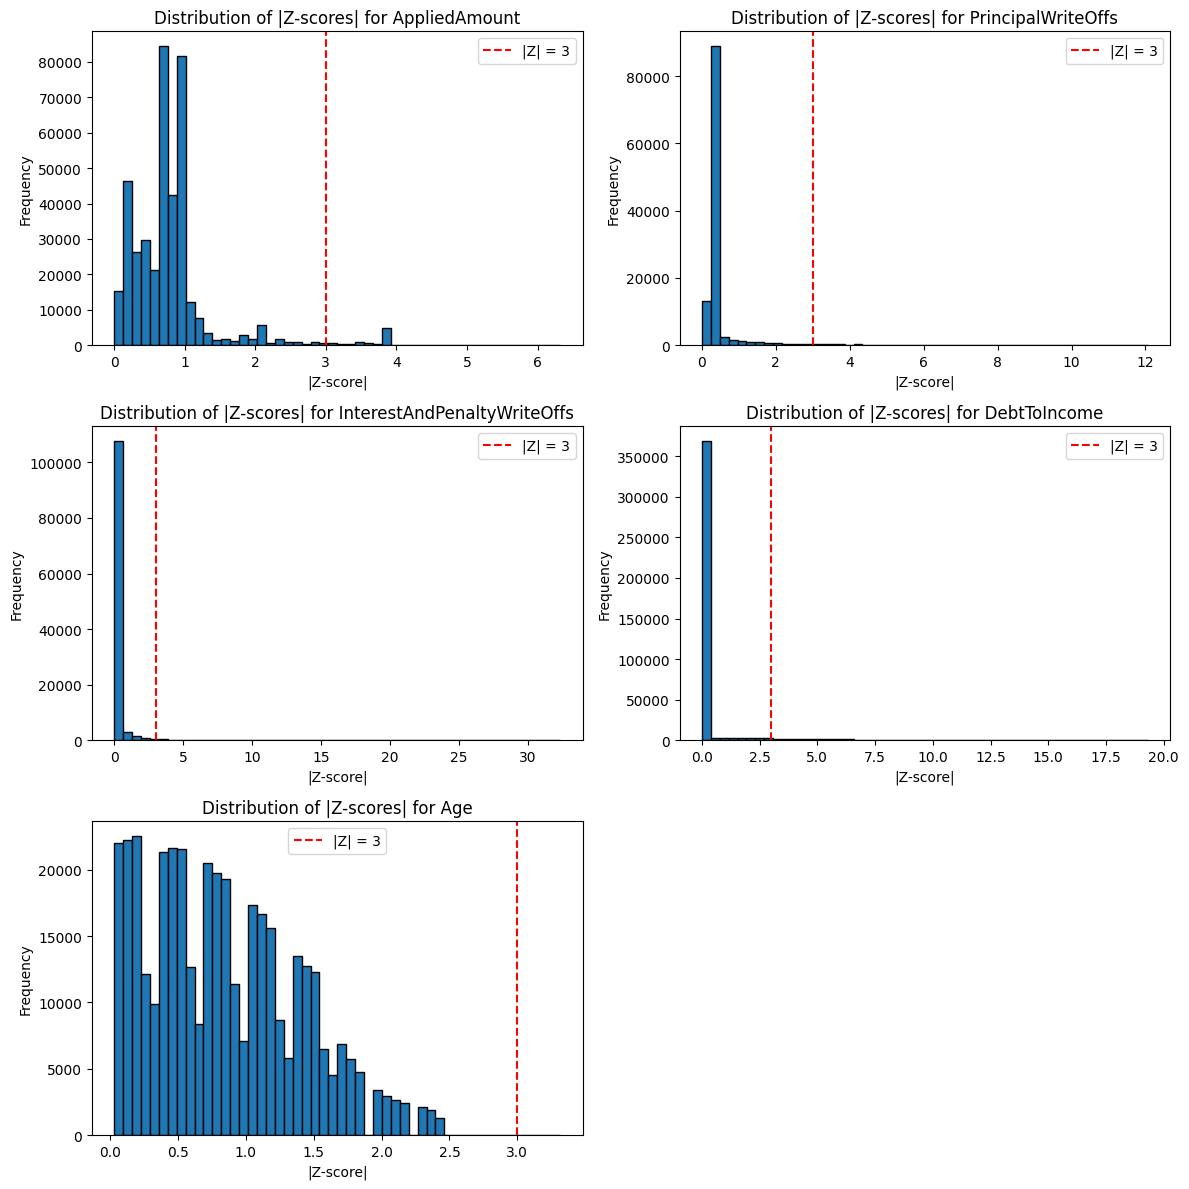

In [14]:
# Histogram of |Z-scores| for multiple features

features = [
    'AppliedAmount',
    'PrincipalWriteOffs',
    'InterestAndPenaltyWriteOffs',
    'DebtToIncome',
    'Age',
]

# Compute layout for subplots
n = len(features)
ncols = 2
nrows = (n + ncols - 1) // ncols  # ceil division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for ax, feature in zip(axes, features):
    # dropna, compute absolute Z-scores
    data = df[feature].dropna()
    zs = np.abs(stats.zscore(data))

    # plot histogram
    ax.hist(zs, bins=50, edgecolor='k')
    ax.axvline(3, color='r', linestyle='--', label='|Z| = 3')
    ax.set_title(f'Distribution of |Z-scores| for {feature}')
    ax.set_xlabel('|Z-score|')
    ax.set_ylabel('Frequency')
    ax.legend()

# turn off any unused subplots
for ax in axes[len(features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()